# TILD (NVT) -- Harmonic oscillators to interacting atoms

### Introduction

This notebook is an example of the 'ProtocolTILDNVTPar' job in pyiron_contrib, which can be used to find the free energy difference $\Delta F$ between two systems of atoms $\mathrm{A}$ and $\mathrm{B}$ in a canonical ($NVT$) ensemble, given by the formula,

$\Delta F_\mathrm{A\rightarrow B}(N, V, T) = \int_0^1 \langle U_\mathrm{B}(\lambda) - U_\mathrm{A}(\lambda) \rangle_{(\lambda, N, V, T)} d\lambda$,

where $\lambda$ is the coupling parameter and $U$ is the potential energy of the system.

#### Harmonic oscillators to interacting atoms

Here, we find the free energy difference between a system of non-interacting harmonic oscillators (Debye atoms) (as system $\mathrm{A}$) and a system of fully interacting atoms (as system $\mathrm{B}$).

### Pre-job setup

In [1]:
# imports

import numpy as np
import matplotlib.pyplot as plt

from pyiron_atomistics import Project
import pyiron_contrib

In [2]:
# define project

pr = Project('tild_harm_to_eam')
pr.remove_jobs(recursive=True)

#### Inputs

In [4]:
# structure specific
element = 'Al'
crystal_structure = 'fcc'
supercell = 3
potential = '2008--Mendelev-M-I--Al--LAMMPS--ipr1'
a = 4.073603  # obtained from calc_md at 300K. 

# tild specific
temperature = 300.
n_lambdas = 3  # number of 'lambda'/integration points
n_steps = 100  # MD steps
thermalization_steps = 10 # number of steps to equilibrate the system for
sampling_steps = 5  # collect a 'sample' every 'sampling_period' steps 
convergence_steps = 50  # number of steps after which to check for convergence
fe_tol = 1e-3  # convergence criterion 0.1 meV 

# cluster specific
queue = 'cmti'
phon_cores = 2
phon_run_time = 1800  # in seconds
tild_cores = n_lambdas  # if running on the headnode, use 1! Otherwise, set to n_lambdas
tild_run_time = 14400  # in seconds

#### 0 K relaxation

In [5]:
pr_zero = pr.create_group('ionic_relaxation')

zero = pr_zero.create.job.Lammps('zero')
zero.structure = pr.create.structure.bulk(
    name=element, 
    crystalstructure=crystal_structure, 
    cubic=crystal_structure.lower() in ['fcc', 'bcc'],
    orthorhombic=crystal_structure.lower() in ['hcp']
).repeat(supercell)
n_atoms = len(zero.structure.positions)
zero.potential = potential
zero.calc_minimize(pressure=None)  # we keep the volume constant! (because we obtain the lattice constant from MD)
zero.run()

zero_k_energy = zero.output.energy_pot[-1]

The job zero was saved and received the ID: 971


/home/raynol025/pyiron/pyiron_atomistics/pyiron_atomistics/lammps/units.py:201: UserWarning: Warning: Couldn't determine the LAMMPS to pyiron unit conversion type of quantity steps. Returning un-normalized quantity
  warnings.warn(message="Warning: Couldn't determine the LAMMPS to pyiron unit conversion type of quantity "
/home/raynol025/pyiron/pyiron_atomistics/pyiron_atomistics/lammps/units.py:201: UserWarning: Warning: Couldn't determine the LAMMPS to pyiron unit conversion type of quantity indices. Returning un-normalized quantity
  warnings.warn(message="Warning: Couldn't determine the LAMMPS to pyiron unit conversion type of quantity "
/home/raynol025/pyiron/pyiron_atomistics/pyiron_atomistics/lammps/units.py:201: UserWarning: Warning: Couldn't determine the LAMMPS to pyiron unit conversion type of quantity velocities. Returning un-normalized quantity
  warnings.warn(message="Warning: Couldn't determine the LAMMPS to pyiron unit conversion type of quantity "
/home/raynol025/pyiro

#### Option A: Force constants from PhonopyJob

Note: EITHER force constants (Debye atoms) OR a spring constant (Einstein atoms) can be provided as inputs to the HessianJob, but not both!

In [6]:
# setup phonopy jobs -- to get the force constants!

pr_phon = pr.create_group('phonons')

phon_ref_job = pr_phon.create_job(pr.job_type.Lammps, 'phon_ref')
phon_ref_job.structure = zero.get_structure()
phon_ref_job.potential = potential

phonopy_job = phon_ref_job.create_job(pr.job_type.PhonopyJob,'phonopy_job')
phonopy_job.input['interaction_range'] = np.amin(np.linalg.norm(zero.get_structure().cell.array, axis=0)) - 1e-8

# cluster inputs
phonopy_job.server.cores = phon_cores
# phonopy_job.server.queue = queue
# phonopy_job.server.run_time = phon_run_time

# run_job
phonopy_job.run()

The job phonopy_job was saved and received the ID: 972
The job phon_ref_0 was saved and received the ID: 973


/home/raynol025/pyiron/pyiron_atomistics/pyiron_atomistics/lammps/units.py:201: UserWarning: Warning: Couldn't determine the LAMMPS to pyiron unit conversion type of quantity indices. Returning un-normalized quantity
  warnings.warn(message="Warning: Couldn't determine the LAMMPS to pyiron unit conversion type of quantity "
/home/raynol025/pyiron/pyiron_atomistics/pyiron_atomistics/lammps/units.py:201: UserWarning: Warning: Couldn't determine the LAMMPS to pyiron unit conversion type of quantity velocities. Returning un-normalized quantity
  warnings.warn(message="Warning: Couldn't determine the LAMMPS to pyiron unit conversion type of quantity "
/home/raynol025/pyiron/pyiron_atomistics/pyiron_atomistics/lammps/units.py:201: UserWarning: Warning: Couldn't determine the LAMMPS to pyiron unit conversion type of quantity steps. Returning un-normalized quantity
  warnings.warn(message="Warning: Couldn't determine the LAMMPS to pyiron unit conversion type of quantity "


In [7]:
# load phonopy jobs, in case you ran this on the cluster    

if phonopy_job.status == 'finished':
    phon_path = Project(str(pr.base_name) + '/' + str(pr_phon.base_name))
    phonopy_job = phon_path.load(phonopy_job.job_name)
    print('job loaded')
else:
    print('job still running')

job loaded


In [8]:
# extract qh free energies
therm_prop = phonopy_job.get_thermal_properties(temperatures=temperature)
A_qh = therm_prop.free_energies[-1]  # A, because this is the Helmholtz free energy

# get force constants
force_constants = phonopy_job.phonopy.force_constants

#### Option 2: Spring constant

Note: EITHER force constants (Debye atoms) OR a spring constant (Einstein atoms) can be provided as inputs to the HessianJob, but not both!

In [9]:
# # in case you want a calculated guess of a single spring constant

# # obtain a spring constant using 0K structure, by displacing a single atom
# # a random spring constant can also be assumed, for example 1 or 5 eV/Ang^2

# spring_folder = pr.create_group('spring_job')

# # clear any existing spring_constant jobs
# spring_folder.remove_jobs_silently(recursive=True)

# spring_job = spring_folder.create_job(pr.job_type.Lammps, 'spring_job')
# spring_job.structure = zero.get_structure()
# spring_job.potential = potential

# deviations = np.linspace(-0.5, 0.5, num=10)
# restoring_forces = np.empty(deviations.shape)

# spring_job.interactive_open()
# for i, d in enumerate(deviations):
#     spring_job.structure.positions[0, 0] = zero.get_structure().positions[0, 0] + d
#     spring_job.calc_static()
#     spring_job.run()
#     restoring_forces[i] = spring_job.interactive_energy_pot_getter()
# spring_job.interactive_close()

# spring_constant = np.polyfit(deviations, restoring_forces, 2)[0]

# print("A spring constant of {} eV/angstrom^2 was found".format(spring_constant))

### TILDNVT job

#### Reference jobs

The 'ProtocolTILDNVTPar' job takes 'reference jobs' for the systems $\mathrm{A}$ and $\mathrm{B}$ as inputs. Here, we specify system $\mathrm{A}$ as a 'HessianJob' job, into which go the force constants/spring constant. System $\mathrm{B}$ is a 'Lammps' job.

In [10]:
pr_tild = pr.create_group('tild_jobs')

# reference job A -> HessianJob
ref_job_a = pr_tild.create.job.HessianJob('ref_job_a')
ref_job_a.structure = zero.get_structure().copy()
ref_job_a.set_reference_structure(zero.get_structure().copy())
ref_job_a.set_force_constants(force_constants)
ref_job_a.save()

# reference job B -> Lammps
ref_job_b = pr_tild.create_job(pr.job_type.Lammps, 'ref_job_b')
ref_job_b.structure = zero.get_structure().copy()
ref_job_b.potential = potential
ref_job_b.save()

The job ref_job_a was saved and received the ID: 974
The job ref_job_b was saved and received the ID: 975


975

#### Submit and run the job

In [11]:
tild_job = pr_tild.create_job(pr.job_type.ProtoTILDPar, 'tild_job')

# Tip: The documentation for the job can be accessed by running 'tild_job?' after the job has been defined!
    
tild_job.input.temperature = temperature
tild_job.input.ref_job_a_full_path = ref_job_a.path
tild_job.input.ref_job_b_full_path = ref_job_b.path
tild_job.input.n_lambdas = n_lambdas
tild_job.input.n_steps = n_steps
tild_job.input.thermalization_steps = thermalization_steps
tild_job.input.sampling_steps = sampling_steps
tild_job.input.convergence_check_steps = convergence_steps
tild_job.input.fe_tol = fe_tol

# # in addition to these inputs, you can also modify the following inputs
# tild_job.input.lambda_bias = 0.5
# tild_job.input.time_step = 1.
# tild_job.input.temperature_damping_timescale = 100.
# tild_job.input.overheat_fraction = 2.
# tild_job.input.cutoff_factor = 0.5
# tild_job.input.use_reflection = False
# tild_job.input.zero_k_energy = 0. # incase you want to provide an energy offset to the HessianJob

# # set this only if you're running this on your local PC, and/or using MySQL as your DB manager
# tild_job.input.sleep_time = 0.1  

# cluster inputs
tild_job.server.cores = tild_cores
# tild_job.server.queue = queue
# tild_job.server.run_time = tild_run_time

# run_job
tild_job.run()

The job tild_job was saved and received the ID: 976
The job create_jobs_a_0 was saved and received the ID: 977
The job create_jobs_a_1 was saved and received the ID: 978
The job create_jobs_a_2 was saved and received the ID: 979
The job create_jobs_b_0 was saved and received the ID: 980
The job create_jobs_b_1 was saved and received the ID: 981
The job create_jobs_b_2 was saved and received the ID: 982


/home/raynol025/pyiron/pyiron_base/pyiron_base/generic/parameters.py:282: UserWarning: The input in GenericParameters changed, while the state of the job was already finished.
  warnings.warn(
/home/raynol025/pyiron/pyiron_base/pyiron_base/generic/parameters.py:282: UserWarning: The input in GenericParameters changed, while the state of the job was already finished.
  warnings.warn(
/home/raynol025/pyiron/pyiron_base/pyiron_base/generic/parameters.py:282: UserWarning: The input in GenericParameters changed, while the state of the job was already finished.
  warnings.warn(


Convergence not reached in 50 steps. Continuing run...


/home/raynol025/anaconda3/envs/pyiron_atomistics/lib/python3.8/site-packages/numpy/lib/function_base.py:2197: RuntimeWarning: invalid value encountered in <lambda> (vectorized)
  outputs = ufunc(*inputs)
/home/raynol025/pyiron/pyiron_base/pyiron_base/generic/parameters.py:282: UserWarning: The input in GenericParameters changed, while the state of the job was already finished.
  warnings.warn(
/home/raynol025/pyiron/pyiron_base/pyiron_base/generic/parameters.py:282: UserWarning: The input in GenericParameters changed, while the state of the job was already finished.
  warnings.warn(
/home/raynol025/pyiron/pyiron_base/pyiron_base/generic/parameters.py:282: UserWarning: The input in GenericParameters changed, while the state of the job was already finished.
  warnings.warn(


Maximum steps (100) reached. Stopping run.


#### Load the job

In [12]:
if tild_job.status == 'finished':
    path = Project(str(pr.base_name) + '/' + str(pr_tild.base_name))
    tild_job = path.load(tild_job.job_name)  # here we load
    print('job loaded')
else:
    print('job still running')

job loaded


#### Collect output

In [13]:
total_steps = tild_job.output.total_steps[-1]
lambdas = tild_job.output.lambdas[-1]
temperature_mean = tild_job.output.temperature_mean[-1]
temperature_std = tild_job.output.temperature_std[-1]
integrands = tild_job.output.integrands[-1]
integrands_std = tild_job.output.integrands_std[-1]
integrands_n_samples = tild_job.output.integrands_n_samples[-1]
del_A_tild = tild_job.output.tild_free_energy_mean[-1]  # A, because this is the Helmholtz free energy
del_A_tild_std = tild_job.output.tild_free_energy_std[-1]
del_A_tild_se = tild_job.output.tild_free_energy_se[-1]

# # also records output using free energy perturbation method 
# del_A_fep = tild_job.output.fep_free_energy_mean[-1]
# del_A_fep_std = tild_job.output.fep_free_energy_std[-1]
# del_A_fep_se = tild_job.output.fep_free_energy_se[-1]

# NOTE: The Helmholtz free energy from the FEP method returns a non-nan value, only if the systems A and B are 
# very close in potential energy to each other!

#### View output

In [14]:
# Check average temperature of the lambda points

print('mean temperature: {} K'.format(np.mean(temperature_mean)))

mean temperature: 226.5255563800823 K


Lambdas:  [0.  0.5 1. ]
Integrands plot: 


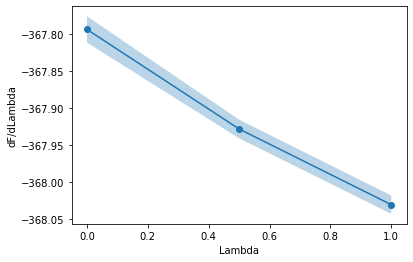

(<Figure size 432x288 with 1 Axes>,
 <AxesSubplot:xlabel='Lambda', ylabel='dF/dLambda'>)

In [15]:
# Some inbuilt functions

print('Lambdas: ', tild_job.get_lambdas())
print('Integrands plot: ')
tild_job.plot_tild_integrands()

In [16]:
# Helmholtz free energy between the quasi-harmonic and interacting system using TILD

print('del_A_tild: {} eV'.format(del_A_tild))

del_A_tild: -367.9228233938346 eV


In [17]:
# qh approximated analytical free energy

print('A_qh: {} meV'.format(A_qh))

A_qh: -0.9000303594806317 meV


In [18]:
# total free energy of the system at this temperature, including all parts

A_tild_eam_per_atom = (A_qh + del_A_tild) / n_atoms
print('A_tild_eam_per_atom: {} eV/atom'.format(A_tild_eam_per_atom))

A_tild_eam_per_atom: -3.415026423641808 eV/atom
